In [1]:
# Imports
import sqlite3 as lite
import pandas as pd
import re
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVR, LinearSVC
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
conn = lite.connect('cycling_big.db')

riders_df = pd.read_sql_query('SELECT * FROM riders;', conn)
races_df = pd.read_sql_query('SELECT * FROM race_results', conn)

print("Amount of rows in races_df: ", races_df[races_df.columns[0]].count())
print("Amount of rows in riders_df: ", riders_df[riders_df.columns[0]].count())

conn.close()

"""
Convert the 'Date' column to DateTime format
Regarding races_df dataframe!
"""

races_df['Date'] = pd.to_datetime(races_df['Date'], errors='coerce', format='%d %B %Y')

# Remove rows where 'Date' is NaT
races_df = races_df.dropna(subset=['Date'])

# Normalize 'Date' to strip out time if it's present (this keeps just the date part)
races_df['Date'] = races_df['Date'].dt.normalize()

# Extract the month and year from the column and put them in their own columns
races_df['Month'] = races_df['Date'].dt.month
races_df['Year'] = races_df['Date'].dt.year

print("Unique values for 'months': ", races_df['Month'].unique(), "\n")
print("Unique values for 'years': ",races_df['Year'].unique())

"""
Converting the timetable to total seconds
"""

def time_to_seconds(time_str):
    # Remove commas and any spaces
    time_str = time_str.replace(',', '').strip()

    # Check the consistency of the time format using regular expressions
    match = re.match(r'(\d{1,2}):(\d{2}):(\d{2})', time_str)
    if match:
        hours, minutes, seconds = map(int, match.groups())
        total_seconds = hours * 3600 + minutes * 60 + seconds
        if total_seconds == 0:
            return np.nan
        return total_seconds

    # Do the same as the loop above, but now for MM:SS format.
    match = re.match(r'(\d{1,2}):(\d{2})', time_str)
    if match:
        minutes, seconds = map(int, match.groups())
        total_seconds = minutes * 60 + seconds
        if total_seconds == 0:
            return np.nan  
        return total_seconds

    # Do the same but for 0:00, 0:01, etc.
    match = re.match(r'(\d{1,2}):(\d{1,2})', time_str)
    if match:
        minutes, seconds = map(int, match.groups())
        total_seconds = minutes * 60 + seconds
        if total_seconds == 0:
            return np.nan 
        return total_seconds
    
    # If format doesn't match, return NaN
    return np.nan

# Apply the conversion function to the 'Time' column
races_df['Time_seconds'] = races_df['Time'].apply(time_to_seconds)

# print(races_df[['Time', 'Time_seconds']].head(10))
# races_df.info()

"""
Converting timelag to total seconds
"""

def timelag_to_seconds(timelag_str):
    # Check if the timelag_str contains missing values
    if pd.isna(timelag_str):
        return np.nan

    timelag_str = timelag_str.lstrip('+').strip()

    match = re.match(r'(\d{1,2}):(\d{2}):(\d{2})', timelag_str)
    if match:
        hours, minutes, seconds = map(int, match.groups())
        return hours * 3600 + minutes * 60 + seconds

    match = re.match(r'(\d{1,2}):(\d{2})', timelag_str)
    if match:
        minutes, seconds = map(int, match.groups())
        return minutes * 60 + seconds
    
    match = re.match(r'(\d+):(\d+)', timelag_str)
    if match:
        minutes, seconds = map(int, match.groups())
        return minutes * 60 + seconds

    return np.nan

races_df['Timelag_seconds'] = races_df['Timelag'].apply(timelag_to_seconds)

races_df['Timelag_seconds'] = races_df['Timelag_seconds'].replace(0.0, np.nan)

print(races_df[['Timelag', 'Timelag_seconds']].head(10))

"""
Converting distance into single numerical value
This means stripping 'km' from string and converting the remaining values into float64
"""

races_df['Length'] = races_df['Length'].str.replace(' km', '', regex=False)

# Convert to numeric and replace 0 with NaN
races_df['Length'] = pd.to_numeric(races_df['Length'], errors='coerce')  # Convert to numeric and handle errors

# Replace 0 values with NaN
races_df['Length'] = races_df['Length'].replace(0.0, np.nan)

# print(races_df['Length'])

"""
Splitting values from 'rdr' and putting the split values into separate columns
"""

# Function to convert the 'rdr' string to separate ranking columns
def extract_rankings(rdr_str):
    try:
        # Converting str to dict
        rankings = ast.literal_eval(rdr_str)
        
        # Extracting ranks, while also handling missing keys
        pcs_rnk = rankings.get('PCS Ranking', np.nan)
        uci_rnk = rankings.get('UCI World Ranking', np.nan)
        alltime_rnk = rankings.get('Specials | All Time Ranking', np.nan)
        
        return pd.Series([pcs_rnk, uci_rnk, alltime_rnk])
    except:
        return pd.Series([np.nan, np.nan, np.nan])

# Apply the function to the 'rdr' column
riders_df[['PCS_Rnk', 'UCI_Rnk', 'AllTime_Rnk']] = riders_df['rdr'].apply(extract_rankings)

# Entries should be turned into numeric values, where errors get turned into NaN
riders_df['PCS_Rnk'] = pd.to_numeric(riders_df['PCS_Rnk'], errors='coerce')
riders_df['UCI_Rnk'] = pd.to_numeric(riders_df['UCI_Rnk'], errors='coerce')
riders_df['AllTime_Rnk'] = pd.to_numeric(riders_df['AllTime_Rnk'], errors='coerce')

# print(riders_df[['fullname', 'PCS_Rnk', 'UCI_Rnk', 'AllTime_Rnk']])

"""
Convert stage types to binary with label encoding
"""

races_df['Stage_Type_bin'] = races_df['Stage_Type'].map({'RR': 0, 'ITT': 1})

"""
Splitting values from 'pps' and putting those values into separate columns.
"""

def extract_points(pps_str):
    try:
        points = ast.literal_eval(pps_str)
        
        day_pnt = np.nan if points.get('One day races', '0') == '0' else points.get('One day races', np.nan)
        gc_pnt = np.nan if points.get('GC', '0') == '0' else points.get('GC', np.nan)
        tt_pnt = np.nan if points.get('Time trial', '0') == '0' else points.get('Time trial', np.nan)
        sprint_pnt = np.nan if points.get('Sprint', '0') == '0' else points.get('Sprint', np.nan)
        climb_pnt = np.nan if points.get('Climber', '0') == '0' else points.get('Climber', np.nan)
        
        return pd.Series([day_pnt, gc_pnt, tt_pnt, sprint_pnt, climb_pnt])
    except:
        return pd.Series([np.nan, np.nan, np.nan, np.nan, np.nan])

riders_df[['Day_Pnt', 'GC_Pnt', 'TT_Pnt', 'Sprint_Pnt', 'Climb_Pnt']] = riders_df['pps'].apply(extract_points)

riders_df['Day_Pnt'] = pd.to_numeric(riders_df['Day_Pnt'], errors='coerce')
riders_df['GC_Pnt'] = pd.to_numeric(riders_df['GC_Pnt'], errors='coerce')
riders_df['TT_Pnt'] = pd.to_numeric(riders_df['TT_Pnt'], errors='coerce')
riders_df['Sprint_Pnt'] = pd.to_numeric(riders_df['Sprint_Pnt'], errors='coerce')
riders_df['Climb_Pnt'] = pd.to_numeric(riders_df['Climb_Pnt'], errors='coerce')


Amount of rows in races_df:  225918
Amount of rows in riders_df:  1042
Unique values for 'months':  [ 1  3  4  5  6  7  8  9 10] 

Unique values for 'years':  [2012 2014 2015 2017 2018 2020 2021]
  Timelag  Timelag_seconds
0   +0:00              NaN
1   +0:04              4.0
2   +0:06              6.0
3   +0:10             10.0
4   +0:10             10.0
5   +0:10             10.0
6   +0:10             10.0
7   +0:10             10.0
8   +0:10             10.0
9   +0:10             10.0


In [3]:
print(riders_df['fullname'])

0          BARDET Romain
1        DUMOULIN Samuel
2          GALLOPIN Tony
3          NAESEN Oliver
4          FRANK Mathias
              ...       
1037      TRONDSEN Trond
1038    VAN MELSEN Kévin
1039     BEULLENS Cédric
1040    DE WINTER Ludwig
1041      DELACROIX Théo
Name: fullname, Length: 1042, dtype: object


In [4]:
riders_df['fullname'] = riders_df['fullname'].str.replace(' ', '_') 
print(riders_df['fullname'])

0          BARDET_Romain
1        DUMOULIN_Samuel
2          GALLOPIN_Tony
3          NAESEN_Oliver
4          FRANK_Mathias
              ...       
1037      TRONDSEN_Trond
1038    VAN_MELSEN_Kévin
1039     BEULLENS_Cédric
1040    DE_WINTER_Ludwig
1041      DELACROIX_Théo
Name: fullname, Length: 1042, dtype: object


In [5]:
"""
Join the rider and race tables together, using the rider_id as an index
"""
print("Amount of rows in races_df post cleanup: ", races_df[races_df.columns[0]].count())
print("Amount of rows in riders_df post cleanup: ", riders_df[riders_df.columns[0]].count())

df = races_df.set_index('rider_id').join(riders_df.set_index('rider_id'), how = 'left')

print("Amount of rows in df: ", df[df.columns[0]].count())

"""
Dropping columns that are not needed for analysis
"""

# Note: fix the long list
df.drop(['Time', 'Timelag', 'rdr', 'pps', 'birthdate', 'rider_url', 'Race_url', 'Stage_url', 'Circuit', 'Race_Name', 'Stage_Name', 'Start', 'Finish', 'Category', 'Stage_Type'], axis=1, inplace=True)

# Additional drops:
df = df.drop(columns=['id', 'Team', 'Date', 'Race_ID', 'Stage_Number', 'Team'])
# Replace all remaining zero values with NaN
df = df.replace(0, np.nan)

print(df.isna().sum())
print("Amount of rows in df after cleanup: ", df[df.columns[0]].count())
print("\ndone")

Amount of rows in races_df post cleanup:  80174
Amount of rows in riders_df post cleanup:  1042
Amount of rows in df:  80174
Rnk                    0
GC                 10059
BiB                    0
Rider                  0
Age                    0
UCI                77527
Pnt                69767
Length              6495
Month                  0
Year                   0
Time_seconds       18435
Timelag_seconds    11212
Stage_Type_bin     72484
fullname           34208
team               34208
country            34208
height             34260
weight             34266
PCS_Rnk            45842
UCI_Rnk            46804
AllTime_Rnk        53300
Day_Pnt            34216
GC_Pnt             34208
TT_Pnt             34631
Sprint_Pnt         34342
Climb_Pnt          34365
dtype: int64
Amount of rows in df after cleanup:  80174

done


'Rnk' or final rank will be used as the target value. This column still contains alot of numerical values for 'DNF', meaning this will need to get cleaned up. Removing non-numericals, like DNF, DNS and OTL, does not impact the amount of available data by a large amount, so we will result in dropping these entries. Since these entries will most likely not contain any useful information (since the rider never finished or fouled), these entries will be dropped.

In [6]:
df['Rnk'] = pd.to_numeric(df['Rnk'], errors='coerce')

### PI 7: Part 3


#### 1.1 Appropriate Machine Learning Models
In this section, the selection of supervised machine learning models in the context of the current dataset will be discussed.

#### 1.2.1 Random Forest
*Random forest* is an ensemble method, that makes use of bootstrapping catergorical and regression trees (cart). As stated in *part 2* of the assignment, cart is a decision tree that classifies records based on the conditions in the *decision nodes*, where the final classification, or regression, is determined in the *leaf nodes*. See the code from <code>pi7-2.ipynb</code> for a more in-depth explanation of decision trees.


**What is ensemble learning?**
- Ensemble learning is a model that will construct a number of models, with the aim to improve its prediction rate.
Two popular ensemble methods include *bagging* (Bootstrap Aggregation) and *boosting*. With bagging, weak models are trained in parallel, where each model learns from a given partition of the dataset. The results from each of these models are then combined by either averaging (regression) or voting (classification). With boosting, a sequential method, each model is trained on a weighted training set, where each model corrects the weights based on the error from its predecessors.

The random forest method will, with regression, create multiple decision trees during training, where the output is the average prediction of the trees.
Standalone trees are prone to high variance and overgrowing, resulting in overfitting. Random forest aims to overcome this by selecting a random set of features for a decision tree, where each tree will make a prediction based on the given features. In the final step, all predictions from the trees are averaged (regression). This provides a degree of randomness for the model, gaining the benefit of:
- Reducing overfitting: by using different subsets of features, this model reduces the risk of training on only a specific subset specific patterns
in the dataset.
- Generalization: by combining predictions from multiple trees, a wider range of patterns is captured in the dataset, which makes the model moder generalized. 

##### 1.2.3 Implementation
Below is an implementation of random forest on the current dataset.

In [7]:
# Prepare dataframe with only numericals, because regression
# Variable selection will be done later
df_ml = df.select_dtypes(include='number')

In [8]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80174 entries, 659ed585810c65fe22255a5e4a9b7838 to 0292146b9196ec7a98903cb50dae48cd
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rnk              74955 non-null  float64
 1   GC               70115 non-null  float64
 2   Age              80174 non-null  int64  
 3   UCI              2647 non-null   float64
 4   Pnt              10407 non-null  float64
 5   Length           73679 non-null  float64
 6   Month            80174 non-null  int32  
 7   Year             80174 non-null  int32  
 8   Time_seconds     61739 non-null  float64
 9   Timelag_seconds  68962 non-null  float64
 10  Stage_Type_bin   7690 non-null   float64
 11  height           45914 non-null  float64
 12  weight           45908 non-null  float64
 13  PCS_Rnk          34332 non-null  float64
 14  UCI_Rnk          33370 non-null  float64
 15  AllTime_Rnk      26874 non-null  float64
 16  Day_P

Datapoints from the lower 20% and upper 80% are removed from the dataset. This reduces the size of the dataset significantly, making training
computationally more feasible in the later stages and will remove any outliers.

In [9]:
q_low = df_ml.quantile(0.2)
q_hi = df_ml.quantile(0.8)

df_filtered = df_ml[(df_ml < q_hi) & (df_ml > q_low)]

Missing entries will be filled using the mean value, making more data available for training. Mean was chosen, since this method is 
computationally inexpensive, making the process more feasible timewise. This does degrade accuracy in finding underlying patterns.

In [10]:
imp = SimpleImputer(strategy='mean').set_output(transform='pandas')

imp.fit(df_filtered)
df_filtered = imp.transform(df_filtered)

/home/th0miz/Documents/School/DatSci_PI7-1/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Stage_Type_bin']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [11]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80174 entries, 659ed585810c65fe22255a5e4a9b7838 to 0292146b9196ec7a98903cb50dae48cd
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rnk              80174 non-null  float64
 1   GC               80174 non-null  float64
 2   Age              80174 non-null  float64
 3   UCI              80174 non-null  float64
 4   Pnt              80174 non-null  float64
 5   Length           80174 non-null  float64
 6   Month            80174 non-null  float64
 7   Year             80174 non-null  float64
 8   Time_seconds     80174 non-null  float64
 9   Timelag_seconds  80174 non-null  float64
 10  height           80174 non-null  float64
 11  weight           80174 non-null  float64
 12  PCS_Rnk          80174 non-null  float64
 13  UCI_Rnk          80174 non-null  float64
 14  AllTime_Rnk      80174 non-null  float64
 15  Day_Pnt          80174 non-null  float64
 16  GC_Pn

X represents the predictor values (row 1 to n), y represents the target values (ranking).

In [12]:
X = df_filtered.iloc[:, 1:]
y = df_filtered.iloc[:, 0]

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80174 entries, 659ed585810c65fe22255a5e4a9b7838 to 0292146b9196ec7a98903cb50dae48cd
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GC               80174 non-null  float64
 1   Age              80174 non-null  float64
 2   UCI              80174 non-null  float64
 3   Pnt              80174 non-null  float64
 4   Length           80174 non-null  float64
 5   Month            80174 non-null  float64
 6   Year             80174 non-null  float64
 7   Time_seconds     80174 non-null  float64
 8   Timelag_seconds  80174 non-null  float64
 9   height           80174 non-null  float64
 10  weight           80174 non-null  float64
 11  PCS_Rnk          80174 non-null  float64
 12  UCI_Rnk          80174 non-null  float64
 13  AllTime_Rnk      80174 non-null  float64
 14  Day_Pnt          80174 non-null  float64
 15  GC_Pnt           80174 non-null  float64
 16  TT_Pn

A train-test split is also made, where the models are able to train on 80% of the dataset, and tested/validated on the remaining 20%.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

#### actual implement
Below is the actual implementation of the random forest regression model. A pipeline is set up to enable feature selection in a more concise statement, making the code more concise. Feature selection is performed by first training a model to extract the most important variables in the first model. Next, those captured variables are used for training the actual model. This makes training more complex timewise, but it does seem to improve accuracy rating and pattern capturing.

In [33]:
forest = RandomForestRegressor(n_estimators=100)
forest.fit(X_test, y_test)


# Hyperparameters are adjusted to findings from random search cv
pipeline_forest = Pipeline([
    ('feature_selection', SelectFromModel(estimator=forest)),
    ('forest_regression', RandomForestRegressor(n_estimators=100, random_state=42, min_samples_split=5))
])

pipeline_forest.fit(X_train, y_train)

score = pipeline_forest.score(X_test, y_test)
print(f"Pipeline test score: {score}")

y_pred_dtr = pipeline_forest.predict(X_test)

Pipeline test score: 0.30190076820878364


#### 1.3.1 Histogram-based Gradient Boosting Regression


In the following section, *histogram-based gradient boosting regression* will be discussed. 

This machine learning model makes use of *gradient boosting* and the construction of histogram-based features.

*Gradient boosting* is an ensemble method which makes use of regression trees. This is a boosting method, which works by building multiple, weaker, prediction models in sequence. Each time a model is constructed, it will (try to) predict the error that is left over by its model, and uses this information to build the next model. Gradient boosting makes use of combining predictions of multiple weak learners, usually decision trees.


**How does Hist Gradient Boosting work?**
This model is similar to gradient boosting, as it is an ensemble technique which uses boosting, but instead of using decision trees as weak learners, it makes use of histograms. Using histograms is computationally more efficient, making it faster compared to traditional gradient boosting, especially on larger datasets. Building a histogram has a notation of $O(nfeatures​×n)$, whereas gradient boosting is of $O(nfeatures​×nlog(n))$.

This provides the following advantages:
- Faster training times.
- It can handle larger datasets.
- Data does not need to be normalized.
- Histogram-based can handle non-linear interaction.

##### 1.3.3 Implementation
See below for the implementation of histogram-based gradient boosting.

In [15]:
X_test.shape, y_test.shape

((16035, 19), (16035,))

In [35]:
# Pipeline does not perform any special actions in this case
pipeline_hgb = Pipeline([
    ('hgb', HistGradientBoostingRegressor(loss='poisson', max_bins=255, max_iter=300, max_depth=10, learning_rate=0.2, ))
])

pipeline_hgb.fit(X_train, y_train)

y_pred_hgb = pipeline_hgb.predict(X_test)

#### 1.4 Support Vector Regression (SVR)
In the following section, SVR will be discussed and showcased.

SVR is a type of learning model, found in the set of models from Support Vector Machines (SVM). SVM is a supervised model that can handle both unstructured data as well as nonlinear relationships in high dimensional spaces. This is made possible due to a nifty feature of this type of model: the *kernel trick* or also called *kernel method*.


Svr works by mapping the 2D space, wherein the samples and target values live, to a higher dimension using the *kernel trick*. It will then
map a hyperplane in this, now multidimensional, space where the data is present. The goal for the usage of this hyperplane is to find the space where the least amount of error is present between the predicted values and the actual values. This hyperplane will then be used for making new predictions on new data.

The kernel trick is the main property that gives svm the ability to use a higher-dimensional space. It works by mapping the datapoints into a higher-dimensional space, where the use of a *kernel function* computes the similarity between two points in the original space. There are several algorithms for performing this kernel function, like *linear kernel*, *polynomial kernel* and *radial basis function (RBF) kernel*. So, the kernel function will calculate similarity between datapoints in the original space, and will in turn calculate dot products, based on these similarities, in the higher dimensional space. The svr algorithm will then find a hyperplane between the dot products, where the error between predicted values and actual values are minimal. This hyperplane is then used for making predictions on new data.

In [18]:
# Another pipeline setup to standardize the data
# before performing svr on the data
# RBF kernel method is used.

pipeline_svr = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf', C=1.0, epsilon=0.2))
])

pipeline_svr.fit(X_train, y_train)

y_pred_svr = pipeline_svr.predict(X_test)

#### 2.1 Metrics for Models

In the following section, metrics for analyzing the performance of the used models will be explained and demonstrated.

Since regression models are being used, the following general metrics will be used:
- Mean absolute error (MAE) and mean absolute percentage error (MAPE).
- Coefficient of determination ($R^2$).

For random forest, feature importance will be used as a metric for evaluating the amount times a feature is used in each tree of the model.

##### 2.2 Mean Absolute (Percentage) Error


With MAE, the magnitude of the average absolute error, or also called deviation, is determined.
For MAPE, the same is achieved as with MAE, except it will return this as a precentage. Thus, this measure gives a percentage score of how predictions deviate from the actual values. 

Below, the MAE and MAPE for each of the models will be given, and will be interpreted.

In [37]:
mae_dtr = mean_absolute_error(y_test, y_pred_dtr)
mape_dtr = mean_absolute_percentage_error(y_test, y_pred_dtr)

mae_hgb = mean_absolute_error(y_test, y_pred_hgb)
mape_hgb = mean_absolute_percentage_error(y_test, y_pred_hgb)

mae_svr = mean_absolute_error(y_test, y_pred_svr)
mape_svr = mean_absolute_percentage_error(y_test, y_pred_svr)

print("Random forest regression:\n\nMean absolute error: ", mae_dtr, "\nMean absolute percentage error: ", mape_dtr,
      "\n\nHistogram-based gradient boosting:\nMean absolute error: ", mae_hgb, "\nMean absolute percentage error: ", mape_hgb,
      "\n\nSupport vector regression:\nMean absolute error: ", mae_svr, "\nMean absolute percentage error: ", mape_svr)

Random forest regression:

Mean absolute error:  11.718033131994183 
Mean absolute percentage error:  0.17351675614395565 

Histogram-based gradient boosting:
Mean absolute error:  12.175877989606153 
Mean absolute percentage error:  0.1803830237454865 

Support vector regression:
Mean absolute error:  12.60602342048053 
Mean absolute percentage error:  0.19033841213374497


Looking at our metrics, the following can be noted:


For mean absolute error, which means the average distance that the model was off from making a correct prediction on an unseen dataset, is 
the lowest for random tree regression, where it was off by 11 points on average. It also has the lowest rate for mean absolute percentage error, where it was off by around 17,4% on average. Histogram-based gradient boosting and support vector regression had about the same results, but they both scored lower on these metrics. 

##### 2.3 Coefficient Determination
Coefficient determination, or also called a $R^2$ score, is a measure that evaluates the goodness of a fit of a regression model. With this score, the proportion to which a regression model adapted to the underlying relations between predictor and target variables is expressed, with a number between 0 and 1. The lower the score, the less a model was able to explain the variation in the dependent variable from its independent variables and vice versa. So, a low score that is closer to 0 explains that the model is a poor fit to the data and that the independent variables do not explain much of the variation to the dependent variable. For a higher score closer to 1, the model will seem like a good fit to the data, and that the independent variables explain most of the variation in the dependent variable. This method works best when variables have linear relationships.

$R^2$ score should not be used as the only metric for a model, since it does not explicitly score the predictive power of a trained model, but it should be used as a metric in combination with other metrics, such as mean absolute error for example.

In [32]:
r2_dtr = r2_score(y_test, y_pred_dtr)
r2_hgb = r2_score(y_test, y_pred_hgb)
r2_svr = r2_score(y_test, y_pred_svr)

print(" . . R2 scores . . \n\nR^2 for random forest: ", r2_dtr,
      "\nR^2 for histogram-based gradient boost: ", r2_hgb,
      "\nR^2 for support vector regression: ", r2_svr)

 . . R2 scores . . 

R^2 for random forest:  0.28729673106258613 
R^2 for histogram-based gradient boost:  0.22437971684893832 
R^2 for support vector regression:  0.11078191543273053


As seen above, random forest was able to capture most of the underlying relationships between dependent and independent variables, compared to random forest and svr. It was able to explain around 28,7% of the variation in the predicted ranking of a cyclist, that was explained by the characteristics of the given cyclists. Histogram-based gradient boosting comes in second and svr comes in last.

Given the $R^2$ scores, it can be concluded that the supervised learning models have a rather poor fit, since a score of 0.5 and up would indicate better predictive power. This could be due to a number reasons, such as overfitting due to the preprocessing stage or the fact that relationships are non-linear.

##### 2.4 Feature Importance
Below are the features that random forest deemed as the most significant/the strongest predictor values that have the most influence on the target value.

In [21]:
importances = forest.feature_importances_

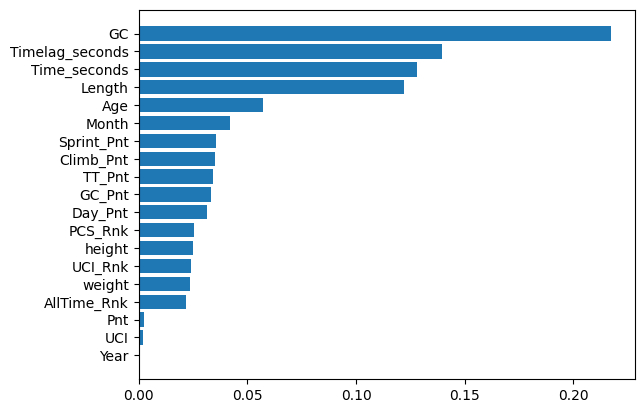

In [22]:
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

From this, it can be concluded that 'GC' was deemed as the most important value for making decisions. This could be due to the fact that it is actually a good predictor value, or it could be a result of imputating by the mean during preprocessing.

#### 3.1.1 Cross-validation

Cross validation (cv) is the act of splitting the dataset, that will be used for the training of a machine learning model.
In this section, the results of research about the preparation of data for cross-validation will be discussed.

Lets start off by evaluating the meaning of cross validation.

When an entire dataset is both used for training and testing the model, it will be very accurate, since the model will use the memorized labels during training for testing its own performance. This is also called *overfitting*, where the model memorized the data instead of learning from it. Thus, it is good practice to hold out a part of the dataset for testing, since the model has never used this partition of the dataset for training purposes. Cv takes this a step further, by splitting the dataset into a training and a testing partition. With this, multiple instances of a model will be trained, where each model will have the test partition shifted around. By iterating over different splits during each sequentially trained model, a more accurate claim can be made for the performance of the trained model. See below for a visual representation.


![alt text](image.png)


[Scikit-learn](http://example.com)


With this, the basics of *k-fold cross-validation* (k-cv), and thus cv itself, have been outlined, where the training set is split into *k* smaller sets, called "k folds".


##### 3.1.2 Cross Validation for Hyperparameters

However, the data used for training is not the only reason the prediction power of a model can be influenced. ML models are tuned based on *hyperparameters* to control their behaviour. For instance, the prediction power for a random forest model can rely on the maximum depth of the tree, the minimum number of samples require to allow a split and more. To dive deeper into researching what hyperparameters work best for a given model, cross validation can be used to have a certain model train over the dataset, while iterating through the definitions for hyperparameters. The results from cross validation can be interpreted to make a claim over which hyperparameters work best for a given model.

So in short, it can be stated that the hyperparameter space can be iteratively searched over for the best cross validation score. But how are hyperparameters evaluated? Two methods will be discussed below.

1. **Exhaustive grid search**

With a grid search, the hyperparameters are specified from a grid of parameter values. The values that will be evaluated are predefined in a grid, where in each following evaluation, the next hyperparameter value is evaluated. By doing this, all the possible combinations of predefined hyperparameters are evaluated, which will result in the best combination of parameters that are defined in the grid. This method is one of the more widely used methods for validating the most optimal hyperparameters for a machine learning model.


2. **Randomized parameter optimization**

Randomized parameter optimization takes a different approach to finding the ideal hyperparameters. This method implements a randomized search over the parameters for a model, where each setting is sampled over a range of possible parameters. The main goal of this cv method is to find the best model parameters by training and evaluating the model, see the next chapter for an implementation of randomized search cross validation.

#### 4.1.1 Ideal Hyperparameters

Below is an implementation of *randomized parameter optimization*, or also call *randomized search cross validation*. This will be done for each of the used models: random forest, histogram-based gradient boosting and support vector regression.

In [23]:
"""
Random Forest
"""

# Define hyperparameter grid for RandomForest Classifier
param_grid = { 'n_estimators': [50, 100, 200],
              'max_depth': [None, 5, 10],
              'min_samples_split': [2, 5, 10] }

rf_classifier = RandomForestRegressor()

random_search = RandomizedSearchCV(estimator=rf_classifier,
                                   param_distributions=param_grid,
                                   cv=5,
                                   n_iter=10)

random_search.fit(X_test, y_test)

print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': None}
Best Score: 0.18289787577056232


In [24]:
"""
Histogram-based Gradient Boosting
"""
param_grid_hgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'l2_regularization': [0, 0.1, 1.0]
}

hgb = HistGradientBoostingRegressor()

random_search_hgb = RandomizedSearchCV(estimator=hgb,
                                       param_distributions=param_grid_hgb,
                                       cv=5,
                                       n_iter=10)

random_search_hgb.fit(X_train, y_train)

print("HGB Best Hyperparameters:", random_search_hgb.best_params_)
print("HGB Best Score:", random_search_hgb.best_score_)

HGB Best Hyperparameters: {'max_iter': 300, 'max_depth': None, 'learning_rate': 0.2, 'l2_regularization': 1.0}
HGB Best Score: 0.27361037590434323


In [25]:
"""
Support Vector Regression
"""

param_grid_svr = {
    'C': [0.1, 1.0, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'poly', 'rbf']
}

svr = SVR()

random_search_svr = RandomizedSearchCV(estimator=svr,
                                       param_distributions=param_grid_svr,
                                       cv=5,
                                       n_iter=10)

random_search_svr.fit(X_train, y_train)

print("SVR Best Hyperparameters:", random_search_svr.best_params_)
print("SVR Best Score:", random_search_svr.best_score_)

'\nSupport Vector Regression\n\nparam_grid_svr = {\n    \'C\': [0.1, 1.0, 10],\n    \'epsilon\': [0.1, 0.2, 0.5],\n    \'kernel\': [\'linear\', \'poly\', \'rbf\']\n}\n\nsvr = SVR()\n\nrandom_search_svr = RandomizedSearchCV(estimator=svr,\n                                       param_distributions=param_grid_svr,\n                                       cv=5,\n                                       n_iter=10)\n\nrandom_search_svr.fit(X_train, y_train)\n\nprint("SVR Best Hyperparameters:", random_search_svr.best_params_)\nprint("SVR Best Score:", random_search_svr.best_score_) '

##### 4.1.2 Interpretation
For the random forest regression model, the optimal hyperparameters are as follows:
- <code>n_estimators</code>: this indicates the number of trees present in the "forest". The optimal number is 100.
- <code>min_samples_split</code>: this is the number of samples required to split a node. The optimal number is 5.
- <code>max_depth</code>: this is the amount of depth a tree has, so it controls the depth of the tree. The optimal number is 'none' for no max depth.


For the histogram-based gradient boost regression model, the optimal hyperparameters are as follows:
- <code>max_iter</code>: this is the maximum amount of iterations during the training process. The optimal number is 300.
- <code>max_depth</code>: this is the amount of depth a tree has, so it controls the depth of the tree. The optimal number is 10.
- <code>learning_rate</code>: this represents the speed at which the model learns. The optimal number is 0.2
- <code>l2_regularization</code>: this number represents the extent to which a measure is taken to prevent overfitting, in short. The optimal number was 0 for no L2 regularization.


For SVR, it was not possible to perform random search cross validation, due to computational overhead. The hyperparameters will be explained in short, but no conclusion can be given on the perfect value.
- <code>C</code>: this parameter sets the strength of regularization. Regularization is a technique of helping to mitigate overfitting.
- <code>epsilon</code>: this is associated to how random an action is taken. To put it simply, it trains the model with the aim to be around the same values as predictors, but not to be the exact value of these predictors.
- <code>Kernel</code>: this specifies the type of kernel method that is used in the algorithm.

The best score indicates the average of $R^2$ scores over the left-out test fold for model using the most optimal parameters.
For the random forest model, the score was around 0,177. For histogram-based gradient boosting model, the score is around 0,277.

#### 5.1 Conclusions
To make a conclusion from the research that was performed, the data from the interpretation of the optimal hyperparameters will be used. Since the $R^2$ score is the highest for the histogram-based gradient boosting model, meaning that this model captures the underlying patterns in the dataset best. When this is the case, the model is able to more accurately identify relationships between the features and a target. With this, the model is able to make a better prediction of the target value.

With an $R^2$ value of around 0,277, it would mean that the model learned some of those underlying patterns, but it is still missing out on most of those important relationships. This could be due to a couple of reasons: an incomplete amount of features, where the key inputs for the target value are missing; there was too much noise present in the dataset, meaning that the preprocessing needs improvement; the model might just be too complex, to the point where the model could be overfitting.

The $R^2$ score is not the only metric that should be used for making a conclusion on the performance of a model, since it does not explicitly outline its overall predictive power. For instance, with the ideal hyperparameters found from random search cv, the mean absolute error is lowest for random forest, with a value of around 11. This means that random forest is, on average, off by around 11 ranking points when validating on new data. Compared to histogram-based gradient boosting, which sits around 12 for MAE, using random forest would be more accurate overall.

Taking this into account, the conclusion can be made that a histogram-based gradient boosting regressor would be a model that captures underlying patters better than random forest or svr could, with a slight compromise in overall accuracy. Given this result, histogram-based gradient boosting would be the best solution to training a supervised machine learning model that can help predict the ranking of a given cyclist in their next match, given that the dataset has been properly sanitized and that the important predictor values have been identified. 

#### Bibliography:
Chicco, D., Warrens, M. J., & Jurman, G. (2021). The Coefficient of Determination R-squared Is More Informative than SMAPE, MAE, MAPE, MSE and RMSE in Regression Analysis Evaluation. *PeerJ Computer Science, 7(5)*, e623. ncbi. https://doi.org/10.7717/peerj-cs.623


*Cross-validation: Evaluating Estimator Performance*. (2009). Scikit-Learn.org. https://scikit-learn.org/stable/modules/cross_validation.html


‌*Ensembles: Gradient boosting, random forests, bagging, voting, stacking*. (2022). Scikit-Learn. 
    https://scikit-learn.org/stable/modules/ensemble.html#gradientboostingclassifier-and-gradientboostingregressor


*HistGradientBoostingRegressor*. (n.d.). Scikit-Learn. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html

*Interpreting sklearns’ GridSearchCV best score*. (2018). Stack Overflow. https://stackoverflow.com/questions/50232599/interpreting-sklearns-gridsearchcv-best-score


*Support Vector Regression (SVR)*. (2024). Medium. https://farshadabdulazeez.medium.com/support-vector-regression-svr-8cb1966ff5a0


*Support Vector Regression - Coastal Wiki.* (2024). Coastalwiki.org. https://www.coastalwiki.org/wiki/Support_Vector_Regression

‌
*The Kernel Trick in Support Vector Machine (SVM).* (2022, May 9).  YouTube. https://youtu.be/Q7vT0--5VII?si=UPm5UYwL1Dtsgkhw